# Model development notebook with GPU

## Imports

In [1]:
import model_tools as mt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.utils import shuffle
import random
import scipy.ndimage
random.seed(42)
print('model_tools version:', mt.__version__)
print('tensorflow version: ',tf.__version__)
print('tf datasets version: ', tfds.__version__)
print('matplotlib version:', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

model_tools version: 1.1.0
tensorflow version:  2.0.0
tf datasets version:  1.2.0
matplotlib version: 3.1.1
numpy version:  1.17.2
sklearn version: 0.22
scipy version: 1.3.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print("GPU Available: ", tf.test.is_gpu_available())
print("Eager execution enabled: ", tf.executing_eagerly())

GPU Available:  True
Eager execution enabled:  True


## Model building and summary 

In [3]:
models = ['MLP1', 'MLP2', 'lenet5', 'lenet5_tuned', 'simrad', 'simrad_tuned_a', 'simrad_tuned_b']
md={}
for m in models:
    md[m]=mt.build_model(m)
    md[m].summary()

Model: "MLP1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 420)               430500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               126300    
_________________________________________________________________
output (Dense)               (None, 10)                3010      
Total params: 559,810
Trainable params: 559,810
Non-trainable params: 0
_________________________________________________________________
Model: "MLP2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
__________________________________________

## Training

In [4]:
# Common
BS=64
EPOCHS=10

In [5]:
# Data prep for MLPs
x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(categorical=False, padding=2, flatten=False, y_float=True)
x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
x_train, y_train = shuffle(x_train, y_train)

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000,)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples
{'count': array([4718, 5363, 4792, 4923, 4689, 4346, 4728, 5037, 4660, 4744])}


In [6]:
# Multi Layer Perceptron 1
history_mp1 = md['MLP1'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 8s 56us/sample - loss: 0.2294 - accuracy: 0.9300 - val_loss: 0.0783 - val_accuracy: 0.9770
Epoch 2/10
144000/144000 [==============================] - 7s 51us/sample - loss: 0.0886 - accuracy: 0.9719 - val_loss: 0.0560 - val_accuracy: 0.9817
Epoch 3/10
144000/144000 [==============================] - 9s 60us/sample - loss: 0.0593 - accuracy: 0.9814 - val_loss: 0.0556 - val_accuracy: 0.9821
Epoch 4/10
144000/144000 [==============================] - 7s 48us/sample - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.0545 - val_accuracy: 0.9821
Epoch 5/10
144000/144000 [==============================] - 7s 51us/sample - loss: 0.0321 - accuracy: 0.9893 - val_loss: 0.0598 - val_accuracy: 0.9825
Epoch 6/10
144000/144000 [==============================] - 7s 47us/sample - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0555 - val_accuracy: 0.9835
Epoch 7/10
144000/144000 [=================

In [7]:
# Multi Layer Perceptron 2
history_mp2 = md['MLP2'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 8s 54us/sample - loss: 0.1740 - accuracy: 0.9463 - val_loss: 0.0638 - val_accuracy: 0.9806
Epoch 2/10
144000/144000 [==============================] - 7s 52us/sample - loss: 0.0798 - accuracy: 0.9770 - val_loss: 0.0700 - val_accuracy: 0.9816
Epoch 3/10
144000/144000 [==============================] - 9s 61us/sample - loss: 0.0642 - accuracy: 0.9823 - val_loss: 0.0653 - val_accuracy: 0.9836
Epoch 4/10
144000/144000 [==============================] - 8s 56us/sample - loss: 0.0528 - accuracy: 0.9857 - val_loss: 0.0757 - val_accuracy: 0.9830
Epoch 5/10
144000/144000 [==============================] - 8s 54us/sample - loss: 0.0459 - accuracy: 0.9876 - val_loss: 0.0941 - val_accuracy: 0.9822
Epoch 6/10
144000/144000 [==============================] - 9s 62us/sample - loss: 0.0423 - accuracy: 0.9895 - val_loss: 0.1007 - val_accuracy: 0.9832
Epoch 7/10
144000/144000 [=================

In [8]:
# Data prep for LeNet
x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(categorical=True, padding=2, flatten=False, y_float=False)
x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
x_train, y_train = shuffle(x_train, y_train)

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [9]:
# LeNet
# Image generator
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")
# Train the network
history_lenet = md['lenet5'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.7093 - accuracy: 0.7625 - val_loss: 0.2059 - val_accuracy: 0.9333
Epoch 2/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.4067 - accuracy: 0.8685 - val_loss: 0.1731 - val_accuracy: 0.9442
Epoch 3/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.3439 - accuracy: 0.8901 - val_loss: 0.1556 - val_accuracy: 0.9521
Epoch 4/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.3159 - accuracy: 0.8998 - val_loss: 0.1249 - val_accuracy: 0.9609
Epoch 5/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.2938 - accuracy: 0.9070 - val_loss: 0.1122 - val_accuracy: 0.9664
Epoch 6/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.2783 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9633
Epoch 7/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.2690 - accuracy: 0.9144 - val_loss: 0.1156 -

In [10]:
# LeNet tuned
history_lenet_tuned = md['lenet5_tuned'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.4975 - accuracy: 0.8336 - val_loss: 0.1315 - val_accuracy: 0.9580
Epoch 2/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.2453 - accuracy: 0.9215 - val_loss: 0.1016 - val_accuracy: 0.9670
Epoch 3/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.2063 - accuracy: 0.9344 - val_loss: 0.1028 - val_accuracy: 0.9669
Epoch 4/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.1882 - accuracy: 0.9413 - val_loss: 0.0851 - val_accuracy: 0.9732
Epoch 5/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1737 - accuracy: 0.9445 - val_loss: 0.0771 - val_accuracy: 0.9752
Epoch 6/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1661 - accuracy: 0.9470 - val_loss: 0.0693 - val_accuracy: 0.9771
Epoch 7/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1594 - accuracy: 0.9494 - val_loss: 0.0713 -

In [11]:
# Data prep for Simrad
x_train_crop, x_test_crop, x_val_crop, y_train, y_test, y_val = mt.ecc()
x_train_crop, y_train_crop = mt.expand_dataset(x_train_crop, y_train, 2, sigma=4.0, alpha=16.0, sizex=29, sizey=29)
x_train_crop, y_train_crop = shuffle(x_train_crop, y_train_crop)

x_train shape:  (48000, 28, 28, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [12]:
y_train_crop=y_train_crop.reshape(y_train_crop.shape[0],10)
y_test=y_test.reshape(y_test.shape[0],10)

In [13]:
# Simrad
history_simrad = md['simrad'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9645 - accuracy: 0.6708 - val_loss: 0.3386 - val_accuracy: 0.8854
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.5349 - accuracy: 0.8243 - val_loss: 0.2657 - val_accuracy: 0.9131
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4555 - accuracy: 0.8532 - val_loss: 0.2216 - val_accuracy: 0.9286
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4123 - accuracy: 0.8672 - val_loss: 0.1821 - val_accuracy: 0.9386
Epoch 5/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3869 - accuracy: 0.8760 - val_loss: 0.1669 - val_accuracy: 0.9451
Epoch 6/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3662 - accuracy: 0.8833 - val_loss: 0.1557 - val_accuracy: 0.9480
Epoch 7/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3502 - accuracy: 0.8878 - val_loss: 0.1550 -

In [14]:
# Simrad tuned variation A
history_simrad_tuned_a = md['simrad_tuned_a'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9204 - accuracy: 0.6871 - val_loss: 0.2967 - val_accuracy: 0.9028
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4952 - accuracy: 0.8390 - val_loss: 0.2341 - val_accuracy: 0.9223
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4147 - accuracy: 0.8670 - val_loss: 0.1920 - val_accuracy: 0.9370
Epoch 4/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3726 - accuracy: 0.8817 - val_loss: 0.1402 - val_accuracy: 0.9541
Epoch 5/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3446 - accuracy: 0.8908 - val_loss: 0.1614 - val_accuracy: 0.9486
Epoch 6/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3296 - accuracy: 0.8959 - val_loss: 0.1554 - val_accuracy: 0.9487
Epoch 7/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3129 - accuracy: 0.9009 - val_loss: 0.1370 -

In [15]:
# Simrad tuned variation B
history_simrad_tuned_b = md['simrad_tuned_b'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9139 - accuracy: 0.6914 - val_loss: 0.2998 - val_accuracy: 0.9009
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4840 - accuracy: 0.8444 - val_loss: 0.2138 - val_accuracy: 0.9328
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4051 - accuracy: 0.8713 - val_loss: 0.1712 - val_accuracy: 0.9448
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3633 - accuracy: 0.8850 - val_loss: 0.1559 - val_accuracy: 0.9490
Epoch 5/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3375 - accuracy: 0.8928 - val_loss: 0.1506 - val_accuracy: 0.9512
Epoch 6/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3207 - accuracy: 0.8989 - val_loss: 0.1340 - val_accuracy: 0.9558
Epoch 7/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3074 - accuracy: 0.9028 - val_loss: 0.1258 -

## Metrics

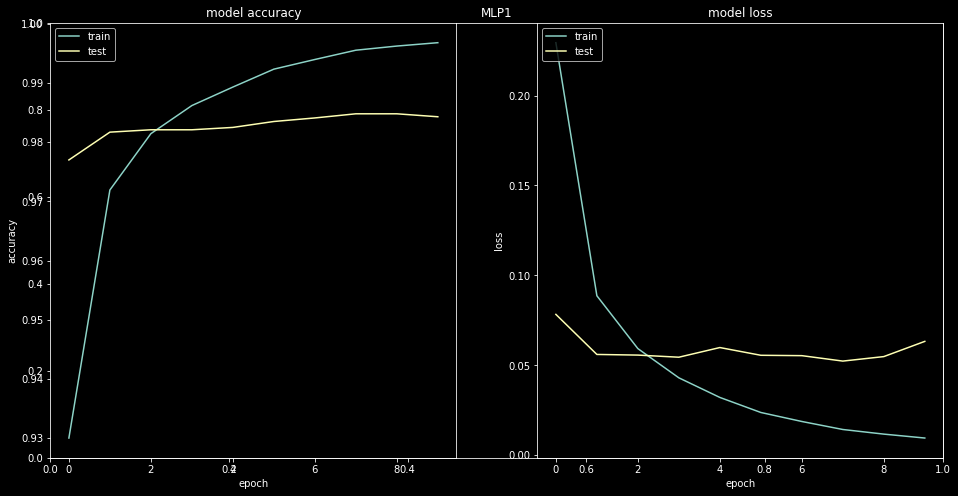

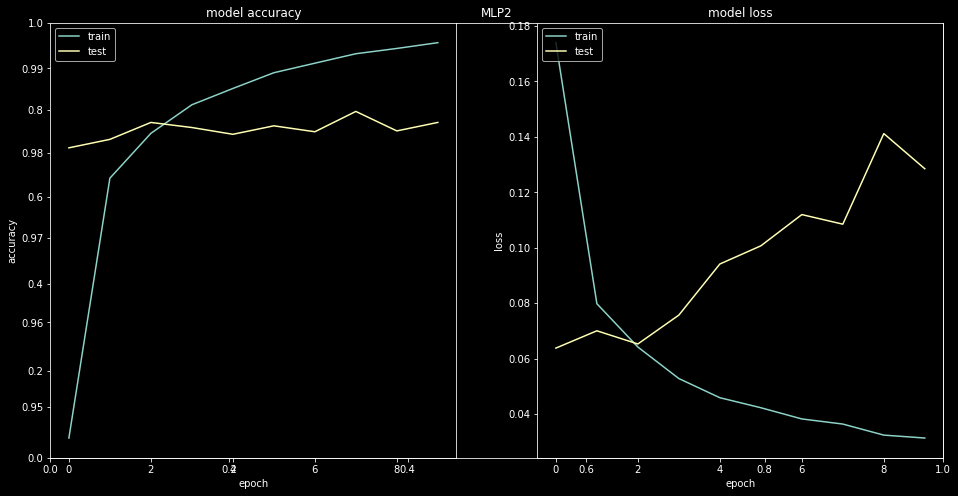

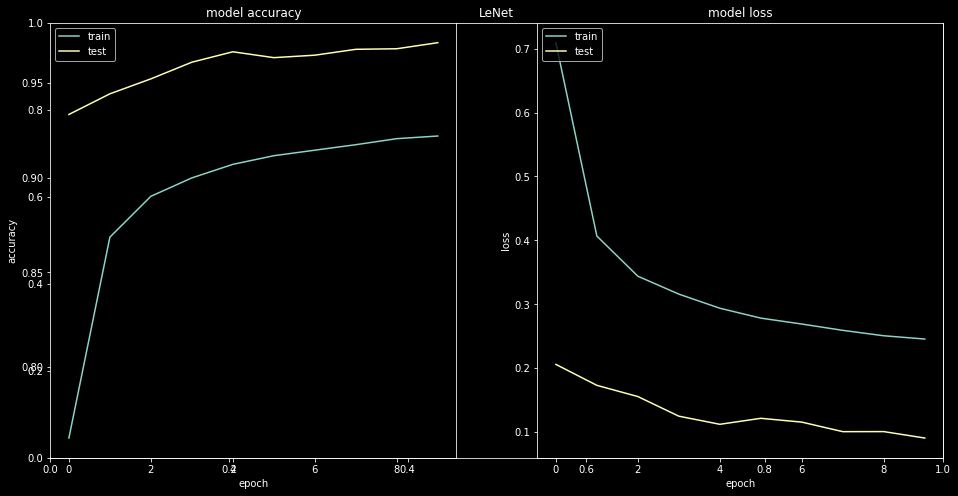

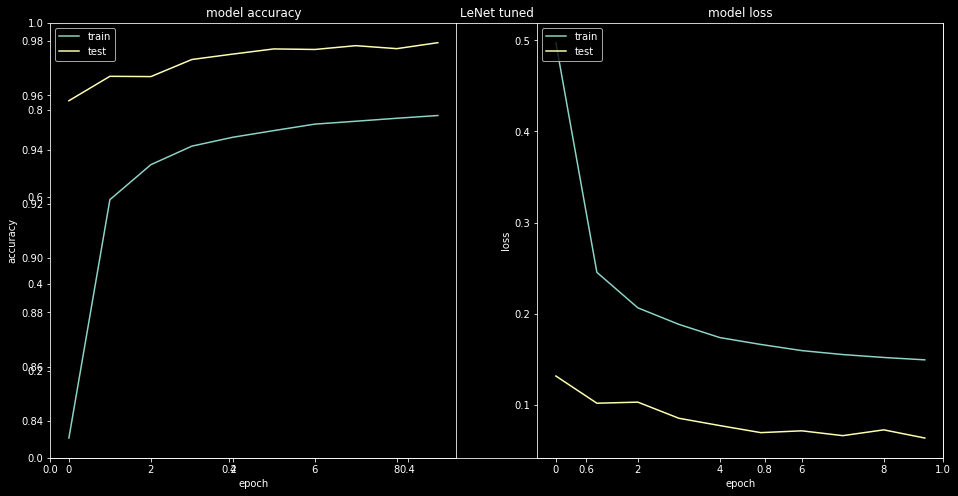

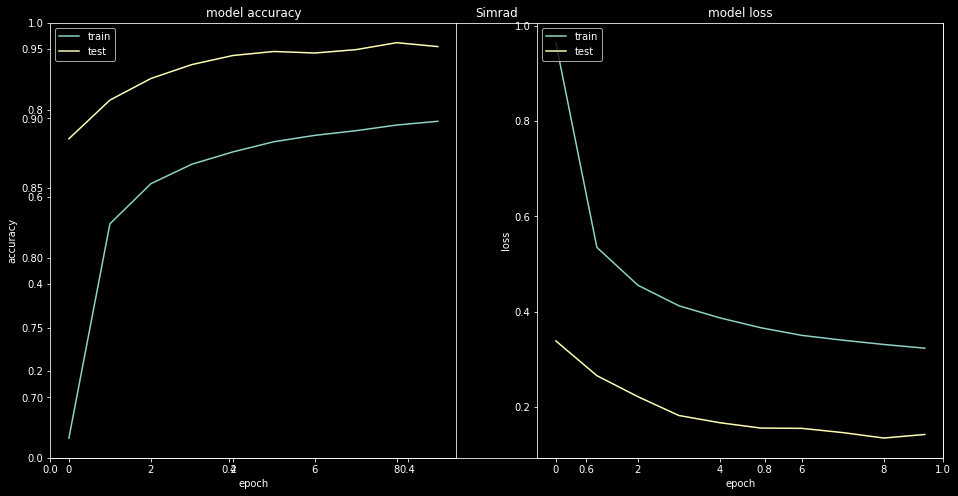

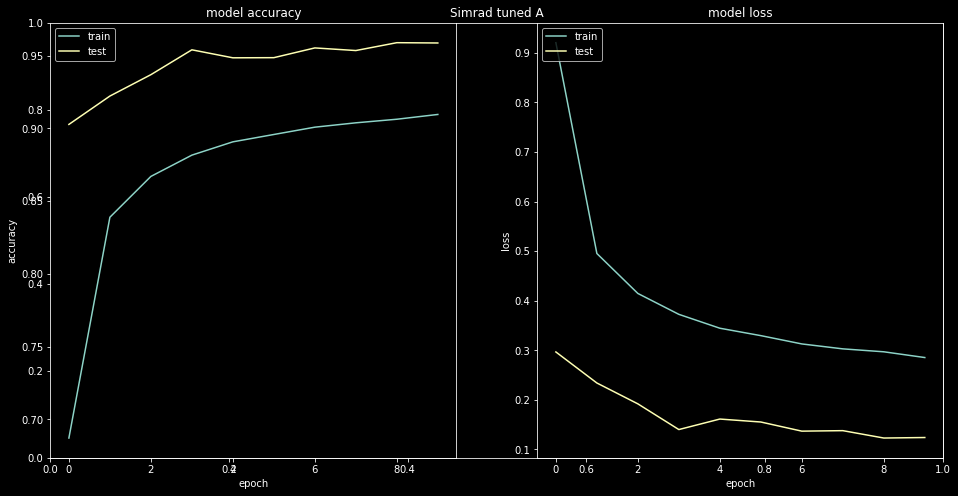

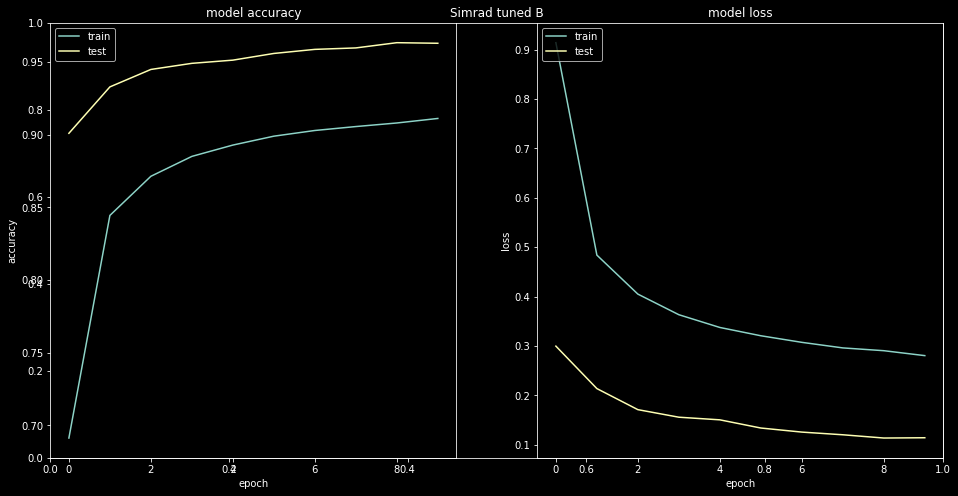

In [16]:
mt.plot_history(history_mp1, 'MLP1')
mt.plot_history(history_mp2, 'MLP2')
mt.plot_history(history_lenet, 'LeNet')
mt.plot_history(history_lenet_tuned, 'LeNet tuned')
mt.plot_history(history_simrad, 'Simrad')
mt.plot_history(history_simrad_tuned_a, 'Simrad tuned A')
mt.plot_history(history_simrad_tuned_b, 'Simrad tuned B')